In [10]:
import nltk
import svgling
from svgling.figure import Caption, SideBySide

# Towards a basic composition system

#### NASSLLI 2022: implementing semantic compositionality
#### Kyle Rawlins, [kgr@jhu.edu](mailto:kgr@jhu.edu)
#### Johns Hopkins University, Department of Cognitive Science

Goal for today: see how a "composition system" is implemented in the lambda notebook, and how it can both used and extended.

## Recap: compositionality (preliminary)

_"Frege's Conjecture"_: semantic composition is function application.

* Linguistic structure $\Rightarrow$ function-argument groupings
* How can we implement this?

## Compositionality: Heim and Kratzer ch. 3

Perhaps the most influential presentation of a compositional system in linguistics (p. 43-44):

1. **TN**: If $\alpha$ is a terminal node, then $[[\alpha]]$ is specified in the lexicon.
2. **NN**: If $\alpha$ is a non-branching node, and $\beta$ its daughter node, then $[[\alpha]] = [[\beta]]$.
3. **FA**: If $\gamma$ is a branching node, $\{\alpha, \beta\}$ the set of $\gamma$'s daughters, and $[[\alpha]]$ is a function whose domain contains $[[\beta]]$, then $[[\gamma]] = [[\alpha]]([[\beta]])$


## Revisiting the toy example

Arithmeticese: object language with one verb ("is"), two coordinators ("plus", "times"), various numbers ("two", "four", ...).
* ignore numbers not in \[1..9\]
* Let's assume a binary branching syntax, including for coordinators.
* Python already has the metalanguage that we need..


```
(1) Two plus two is four
```

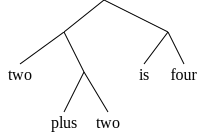

In [11]:
nltk.Tree.fromstring("(((two) ((plus) two)) ((is) four))")

### Arithmeticese: a pure python implementation

In [12]:
# this is one way to write a "curried" function in python:
def plus(x):
    return lambda y: y + x

def isV(x): # `is` is a python reserved word
    return lambda y: x == y

def two():
    return 2

def four():
    return 4

In [13]:
plus(two())(four())

6

In [14]:
isV(plus(two())(two()))(four())

True

Weirdly adequate along a number of dimensions. But?

1. No object/meta-language distinction.
2. Arity enforcement, but no type enforcement.
3. Works, but can't inspect how it works.
4. Relies on the relevant metalanguage operations being present in the programming language.

In [15]:
isV(two())(plus)

False

In [16]:
plus(isV(two())(two()))(four())

5

In [17]:
plus(two())

<function __main__.plus.<locals>.<lambda>(y)>

In [18]:
plus(isV)(two()) # finally, an error

TypeError: unsupported operand type(s) for +: 'int' and 'function'

If you're a python hacker, you might come up with something like this as a solution to 1:

In [19]:
lexicon = {"two": two(),
           "four": four(),
           "plus": plus,
           "is": isV}

lexicon["plus"](lexicon["two"])(lexicon["two"])

4

Even better, we can abstract the notion of "composition" into a function:

In [20]:
def compose(f, a, lex):
    # try looking up f and a in the lexicon, otherwise take them as given
    if f in lex:
        f = lex[f]
    if a in lex:
        a = lex[a]
    return f(a)

compose(compose("plus", "two", lexicon), "two", lexicon)

4

This is essentially what we are aiming at!

But, we need a real solution to 1-4:

1. Object/meta-language distinction.
2. Type enforcement.
3. Introspection / derivational history.
4. Expanding out the logical metalanguage beyond python (which essentially includes an extensional propositional logic only).

**Abstract these ideas** into general functions and classes.

### Side note on the choice of languages

Worth noting that other people doing this work often have picked Haskell exactly because it is arguably a better fit for the task than python.
* Cf. the van Eijck and Unger 2010 text mentioned yesterday.
* Haskell is a functional, strongly typed, programming language.
* Its type system is adaptable/powerful, and can easily line up with what linguists typically assume.

Flip-side: it is not "mainstream" or especially easy to learn. It is not a good first language. It isn't widely in demand in industry jobs. It is not used for introductory computing courses.
* (Jupyter integration is also an advantage, but, there is actually a Haskell [Jupyter kernel](https://github.com/IHaskell/IHaskell)!)

## A starting point: how to implement function application?

**Function Application**: given two linguistic objects, one which is a function $f$ and the other an appropriate argument $a$, the result of composition is $f(a)$.

In a nutshell: all the work is in the metalanguage, in particular, getting a good implementation of _beta reduction_.



## Simple types

Standard(ish) setup:

1. e, n, t are types
2. if $\alpha, \beta$ are types, then so is $\langle \alpha, \beta \rangle$
3. nothing else is a type

If $f$ has type $\langle \alpha, \beta \rangle$, then $f$ is a function from things of type $\alpha$ to things of type $\beta$.
 * That is $\langle \cdot, \cdot \rangle$ is a "type constructor" for functional types.
 * Let's set aside implementation questions for types for the moment.

### A standard definition of Function Application

(After Heim and Kratzer 1998, Coppock and Champollion's 2022 [Invitation to Formal Semantics](https://eecoppock.info/bootcamp/semantics-boot-camp.pdf) ch. 6)

If $\gamma$ is a syntax tree whose subtrees are $\alpha$ and $\beta$, where:
* $[[\alpha]]$ has type $\langle \sigma, \tau \rangle$
* $[[\beta]]$ has type $\sigma$

Then, $[[\gamma]] = [[\alpha]]([[\beta]])$



In [21]:
%%lamb
||two|| = 2
||plus|| = L x_n : L y_n : x + y

$[\![\mathbf{\text{two}}]\!]^{}_{n} \:=\: $${2}$<br />
$[\![\mathbf{\text{plus}}]\!]^{}_{\left\langle{}n,\left\langle{}n,n\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} x_{n} \: . \: \lambda{} y_{n} \: . \: ({x} + {y})$

In [22]:
plus * two # let's switch to notebook and play around with this a bit

CompositionResult(results=[⟦[plus two]⟧ = (λ y_n: (2_n + y_n))], failures=[⟦[two plus]⟧ = Type mismatch: '⟦two⟧ = 2_n'/n and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Function Application), ⟦[plus two]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦two⟧ = 2_n'/n conflict (Predicate Modification), ⟦[plus two]⟧ = Composition failure (PA requires a valid binder) on: ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))) * ⟦two⟧ = 2_n, ⟦[two plus]⟧ = Composition failure (PA requires a valid binder) on: ⟦two⟧ = 2_n * ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))), ⟦[plus two]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦two⟧ = 2_n'/n conflict (Need at least one fully vacuous element)])

In [23]:
(plus * two).trace()

Full composition trace.  1 path:<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 1: $[\![\mathbf{\text{plus}}]\!]^{}_{\left\langle{}n,\left\langle{}n,n\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} x_{n} \: . \: \lambda{} y_{n} \: . \: ({x} + {y})$<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 2: $[\![\mathbf{\text{two}}]\!]^{}_{n} \:=\: $${2}$<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 3: $[\![\mathbf{\text{plus}}]\!]^{}_{\left\langle{}n,\left\langle{}n,n\right\rangle{}\right\rangle{}}$ * $[\![\mathbf{\text{two}}]\!]^{}_{n}$ leads to: $[\![\mathbf{\text{[plus two]}}]\!]^{}_{\left\langle{}n,n\right\rangle{}} \:=\: $$\lambda{} y_{n} \: . \: ({2} + {y})$ <b>[by FA]</b><br />

### Function Application, procedurally

For `a * b`:

1. if `a.content` is a function, and `b.content` is an appropriate argument, then:
    1. return `[[a b]] = a.content(b.content)`
2. if `b.content` is a function, and `a.content` is an appropriate argument, then:
    1. return `[[a b]] = b.content(a.content)`
3. otherwise, fail

In [24]:
plus * plus

CompositionResult(results=[], failures=[⟦[plus plus]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Function Application), ⟦[plus plus]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Function Application), ⟦[plus plus]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Predicate Modification), ⟦[plus plus]⟧ = Composition failure (PA requires a valid binder) on: ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))) * ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))), ⟦[plus plus]⟧ = Composition failure (PA requires a valid binder) on: ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))) * ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))), ⟦[plus plus]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Need at least one fully vacuous element)])

## Metalanguage objects

The lambda notebook metalanguage is implemented via structured python objects that all share a common programmatic inferface.

The `%te` line magic (mnemonic: typed expression) lets you quickly build metalanguage objects:

In [25]:
formula = %te p_t & q_t
display(formula)
display(formula.op) # typed expressions (may) have an operator
display(formula.type) # typed expressions have a type
display(list(formula)) # typed expressions have parts
display(formula.__class__) # the python type of `formula`

(p_t & q_t)

'&'

t

[p_t, q_t]

lamb.meta.BinaryAndExpr

In [26]:
# let's look at a part:
display(formula[0])
display(formula[0].type)
display(formula[0].__class__)

p_t

t

lamb.meta.TypedTerm

## Metalanguage functions

Let's look a bit at a metalanguage function. Its parts are the variable, and the body, and its type is guaranteed to be a functional type.

In [27]:
f = %te L x_n : L y_n : x + y
x = %te 2
f

(λ x_n: (λ y_n: (x_n + y_n)))

In [28]:
f.type

<n,<n,n>>

In [29]:
display(f[0], f[1])

x_n

(λ y_n: (x_n + y_n))

### Function-argument combination

When a function combines with an argument, it builds a composite expression (an "application expression"):

In [30]:
x = %te 2
f(x)

((λ x_n: (λ y_n: (x_n + y_n))))(2_n)

In [31]:
f(x).__class__

lamb.meta.ApplicationExpr

Reduction can be triggered by calling the function `reduce()`. (This works on any meta-language object, but most things aren't reducible!)

In [32]:
f(x).reduce().derivation

1. ((λ x_n: (λ y_n: (x_n + y_n))))(2_n)
 2. (λ y_n: (2_n + y_n))    (Reduction)

All of the hard work is done in this function.

### Variable capture and renaming

What is hard here? Consider the following case (based on an example in Partee, ter Meulen and Wall 1993, _Mathematical Methods in Linguistics_):

In [33]:
f1 = %te L y_e : L x_e : P_<e,t>(x) & Q_<e,t>(y)
x = %te x_e

display(f1, x, f1(x))

(λ y_e: (λ x_e: (P_<e,t>(x_e) & Q_<e,t>(y_e))))

x_e

((λ y_e: (λ x_e: (P_<e,t>(x_e) & Q_<e,t>(y_e)))))(x_e)

How should we reduce this? Need to _alpha-convert_ the bound variable:

In [34]:
f1(x).reduce_all()

(λ x1_e: (P_<e,t>(x1_e) & Q_<e,t>(x_e)))

That is, where reduction would result in a name collision between bound variables, the variables must be systematically renamed. The following would be wrong: $\lambda x_e . P(x) \wedge Q(x)$

### A naive reduction algorithm

Pseudocode. Given a `LFun` object `f`, and an arbitrary `TypedExpr` argument `a`:

1. Check if `f.type` is compatible with `a.type`
2. Return `f[1].subst(f[0], a)` (substitute instances of `f[0]` in `f[1]` with `a`)

Where `t.subst(var, a)`:
1. if `t` is a variable named `var`, return `a`
2. otherwise, for all parts `i` in `t`:
    a. `t[i] = t[i].subst(var, a)`
    b. return the modified `t`


### Adding in alpha conversion

Rather subtle to get right! Somewhat imperfect sketch:

1. find the set `blocklist` of variables used in `f` or in `a`
2. find potential collisions between `f[0]` and any variables in `a`
3. if there is a collision:
    a. find a variable name `x` not in `blocklist`
    b. systematically replace all bound instances in `f[1]` with `x`
4. The tricky part: now we need to recurse and apply this to any lambda terms _within_ `f[1]`, avoiding collisions as well with the renames so far.

* Note: this is definitely still a "naive" algorithm, and can be made much more efficient. (See [director strings](https://link.springer.com/chapter/10.1007/3-540-44881-0_5))
* Note: if a single reduction would substitute in a way that would feed a second reduction, alpha conversion needs to be run separately for that step.

In [35]:
t2 = %te L x_e : (L y_e : L x_e : P_<e,t>(x) & Q_<e,t>(y))(x_e)
display(t2, t2.reduce_all())

(λ x_e: ((λ y_e: (λ x_e: (P_<e,t>(x_e) & Q_<e,t>(y_e)))))(x_e))

(λ x_e: (λ x1_e: (P_<e,t>(x1_e) & Q_<e,t>(x_e))))

In [36]:
t3 = %te (L x_e : (L y_e : L x_e : P_<e,t>(x) & Q_<e,t>(y))(x_e))(y_e)
display(t3, t3.reduce(), t3.reduce_all())

((λ x_e: ((λ y_e: (λ x_e: (P_<e,t>(x_e) & Q_<e,t>(y_e)))))(x_e)))(y_e)

((λ y1_e: (λ x_e: (P_<e,t>(x_e) & Q_<e,t>(y1_e)))))(y_e)

(λ x1_e: (P_<e,t>(x1_e) & Q_<e,t>(y_e)))

***
## Embedding metalanguage in semantic composition

In [37]:
%%lamb
||two|| = 2
||plus|| = L x_n : L y_n : x + y

$[\![\mathbf{\text{two}}]\!]^{}_{n} \:=\: $${2}$<br />
$[\![\mathbf{\text{plus}}]\!]^{}_{\left\langle{}n,\left\langle{}n,n\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} x_{n} \: . \: \lambda{} y_{n} \: . \: ({x} + {y})$

What is the nature of these sorts of definitions?

### Items

`two` and `plus` in this example are python _objects_ of class `lang.Item`. (`lang` is one of the lambda notebook modules.)

* An `Item` is essentially a mapping between a string, representing an object language item, and a single metalanguage object.

In [38]:
display(plus.name, plus.content)

'plus'

(λ x_n: (λ y_n: (x_n + y_n)))

### Objects and classes (object-oriented-programming basics)

A python _object_ is a bundle of data and behaviors, specified by its _class_
* _data_: named variables that are part of the object, e.g. `plus.name`
* _behavior_: functions that interact with some of the object's data in some way

Example: `TypedExpr` is the main metalanguage class, and contains code for type inference, frontend rendering, reduction, variable substitution, etc.
* Other metalanguage objects are _subclasses_ of `TypedExpr`, which means that they extend its behavior in various ways (while keeping the core behavior).

Interesting behavior change: you can change the behavior of most python operators by defining a special class function. E.g. `__call__` lets you change what happens when you use the standard function-argument python notation.

Metalanguage `TypedExpr`s redefine `__call__` so that you can use this notation:

In [39]:
f = %te L x_e : Cat(x)
x = %te A_e
f(x)

INFO (meta): Coerced guessed type for 'Cat_t' into <e,t>, to match argument 'x_e'


((λ x_e: Cat_<e,t>(x_e)))(A_e)

### Composables, etc

The `Item` class is a special case of a general abstract type called `Composable`. Any object that can undergo composition has this type.
* This class is mostly "glue", but is where the `*` operator is implemented, via the `__mul__` special function.
* The `lamb.lang` module contains a variety of subclasses of `Composable`, and mostly you don't need to know which is which.

### CompositionResults

In [40]:
result = plus * two
result

CompositionResult(results=[⟦[plus two]⟧ = (λ y_n: (2_n + y_n))], failures=[⟦[two plus]⟧ = Type mismatch: '⟦two⟧ = 2_n'/n and '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> conflict (Function Application), ⟦[plus two]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦two⟧ = 2_n'/n conflict (Predicate Modification), ⟦[plus two]⟧ = Composition failure (PA requires a valid binder) on: ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))) * ⟦two⟧ = 2_n, ⟦[two plus]⟧ = Composition failure (PA requires a valid binder) on: ⟦two⟧ = 2_n * ⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n))), ⟦[plus two]⟧ = Type mismatch: '⟦plus⟧ = (λ x_n: (λ y_n: (x_n + y_n)))'/<n,<n,n>> and '⟦two⟧ = 2_n'/n conflict (Need at least one fully vacuous element)])

`result` here is a python object of class `lang.CompositionResult`.
* a `CompositionResult` is a set of mappings between input `Composable`s and output metalanguage objects.
* this class is itself a `Composable`.

In [41]:
result.results[0].tree()

DisplayNode instance: HTML rendering only

In [42]:
result.source

'[plus two]'

### Ambiguity in CompositionResults

A `CompositionResult` can contain multiple results, representing ambiguity. For example, via lexical ambiguity. Here's the lexical notation to do this in the lambda notebook:

In [43]:
%%lamb
||bank|| = L x_e : Riverbank_<e,t>(x)
||bank[*]|| = L x_e : Moneybank_<e,t>(x)
||the|| = L f_<e,t> : Iota x_e : f(x)

$[\![\mathbf{\text{bank[0]}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Riverbank}({x})$
<br />$[\![\mathbf{\text{bank[1]}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Moneybank}({x})$<br />
$[\![\mathbf{\text{the}}]\!]^{}_{\left\langle{}\left\langle{}e,t\right\rangle{},e\right\rangle{}} \:=\: $$\lambda{} f_{\left\langle{}e,t\right\rangle{}} \: . \: \iota{} x_{e} \: . \: {f}({x})$

In [44]:
the * bank

CompositionResult(results=[⟦[the bank]⟧ = (ι x_e: Riverbank_<e,t>(x_e)), ⟦[the bank]⟧ = (ι x_e: Moneybank_<e,t>(x_e))], failures=[⟦[bank the]⟧ = Type mismatch: '⟦bank⟧ = (λ x_e: Riverbank_<e,t>(x_e))'/<e,t> and '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> conflict (Function Application), ⟦[the bank]⟧ = Type mismatch: '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> and '⟦bank⟧ = (λ x_e: Riverbank_<e,t>(x_e))'/<e,t> conflict (Predicate Modification), ⟦[the bank]⟧ = Composition failure (PA requires a valid binder) on: ⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e))) * ⟦bank⟧ = (λ x_e: Riverbank_<e,t>(x_e)), ⟦[bank the]⟧ = Composition failure (PA requires a valid binder) on: ⟦bank⟧ = (λ x_e: Riverbank_<e,t>(x_e)) * ⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e))), ⟦[the bank]⟧ = Type mismatch: '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> and '⟦bank⟧ = (λ x_e: Riverbank_<e,t>(x_e))'/<e,t> conflict (Need at least one fully vacuous element), ⟦[bank the]⟧ = Type mismatch: '⟦bank⟧ = (λ x_e: Moneybank_<e,t>(x_e))'/<e,t> and '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> conflict (Function Application), ⟦[the bank]⟧ = Type mismatch: '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> and '⟦bank⟧ = (λ x_e: Moneybank_<e,t>(x_e))'/<e,t> conflict (Predicate Modification), ⟦[the bank]⟧ = Composition failure (PA requires a valid binder) on: ⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e))) * ⟦bank⟧ = (λ x_e: Moneybank_<e,t>(x_e)), ⟦[bank the]⟧ = Composition failure (PA requires a valid binder) on: ⟦bank⟧ = (λ x_e: Moneybank_<e,t>(x_e)) * ⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e))), ⟦[the bank]⟧ = Type mismatch: '⟦the⟧ = (λ f_<e,t>: (ι x_e: f_<e,t>(x_e)))'/<<e,t>,e> and '⟦bank⟧ = (λ x_e: Moneybank_<e,t>(x_e))'/<e,t> conflict (Need at least one fully vacuous element)])

### Computing composition results

Pretty straightforward brute force:

For `a * b`
1. For every composition operation in the system:
    1. If `a` and `b` meet the preconditions of the composition operation `O`, add `O(a,b)` to the list of results
2. Return the list of results

---
## More composition operations

### Predicate modification

(This is again a Heim & Kratzer + Coppock and Champollion hybrid)

**PM**: If $\gamma$ is a syntax tree whose subtrees are $\alpha$ and $\beta$, where:
* $[[\alpha]]$ and $[[\beta]]$ have type $\langle e,t \rangle$

Then, $[[\gamma]] = \lambda x_e . [[\alpha]](x) \wedge [[\beta]](x)$

**Primary uses**: intersective adjectives, relative clauses

#### First try at PM Procedurally

For `a * b`

1. If `a.content` and `b.content` have type $\langle e,t \rangle$, then:
    1. construct a metalanguage object: `LFun(x, BinaryAndExpr(a.content(x), b.content(x))`
    2. Let `f` = the fully reduced form of that object, and return `||a b|| = f`
2. Otherwise, fail

This is surprisingly annoying to implement!

#### The PM combinator

The idea of PM has a different way it can be expressed:

In [45]:
%te L f_<e,t> : L g_<e,t> : L x_e : f(x) & g(x)

(λ f_<e,t>: (λ g_<e,t>: (λ x_e: (f_<e,t>(x_e) & g_<e,t>(x_e)))))

This is what is known as a [combinator](https://plato.stanford.edu/entries/lambda-calculus/#Com).
* In this context, a combinator is simply a function with no free variables.
* See also: [combinatory logic](https://plato.stanford.edu/entries/logic-combinatory/), [CCG](https://www.inf.ed.ac.uk/teaching/courses/nlg/readings/ccgintro.pdf)

#### The combinator trick

Many composition operations can be expressed as combinators.

If $\gamma$ is a syntax tree whose subtrees are $\alpha$ and $\beta$, and $C$ is a combinator designated as a composition operation, where
1. $[[\alpha]]$ has type $\sigma$, and $[[\beta]]$ has type $\tau$,
1. $C$ is a function of type $\langle \sigma, ... \rangle$, and
2. $C([[\alpha]])$ is a function of type $\langle \tau, ... \rangle$

Then $[[\gamma]] = C([[\alpha]])([[\beta]])$

### Existential closure

This operation is commonly assumed in event semantics, and thought of as either a type-shift or a "unary" operation. For simplicity, I show here a variant of EC that operates on type $e$.

**EC**: if $[[\alpha]]$ has type $\langle e, X \rangle$ for some type $X$, then $[[EC(\alpha)]] = \exists x_e : [[\alpha]](x)$

#### Implementing EC

The procedural attempt is straightforward, but again somewhat annoying to implement: build an object that introduces a $\exists$ operator.

Let's instead consider a combinator approach, again.

In [66]:
ec_combinator = %te L f_<e,t> : Exists x_e : f(x)
ec_combinator

(λ f_<e,t>: (Exists x_e: f_<e,t>(x_e)))

In [67]:
lang.get_system().add_unary_rule(ec_combinator, "EC")
lang.get_system()

WARNING (lang): Composition rule named 'EC' already present in system, replacing


Composition system: H&K simple

In [68]:
%lamb ||cat|| = L x_e : Cat_<e,t>(x)
cat.compose()

$[\![\mathbf{\text{cat}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Cat}({x})$

CompositionResult(results=[⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e))], failures=[])

#### Type-shifts

Existential closure is often instead treated as a _type-shift_, applying as needed to get type $t$. Unary combinators can also be used for this.

In [53]:
lang.get_system().add_typeshift(ec_combinator, "EC")
lang.get_system().typeshift = True
lang.get_system()

WARNING (lang): Composition rule named 'EC' already present in system, replacing


Composition system: H&K simple

Let's try it out:

In [54]:
%lamb ||neg|| = L p_t : ~p

$[\![\mathbf{\text{neg}}]\!]^{}_{\left\langle{}t,t\right\rangle{}} \:=\: $$\lambda{} p_{t} \: . \: \neg{} {p}$

In [55]:
neg * cat

CompositionResult(results=[⟦[neg [cat]]⟧ = ~(Exists x_e: Cat_<e,t>(x_e))], failures=[⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Function Application), ⟦[cat neg]⟧ = Type mismatch: '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> and '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> conflict (Function Application), ⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Predicate Modification), ⟦[neg cat]⟧ = Composition failure (PA requires a valid binder) on: ⟦neg⟧ = (λ p_t: ~p_t) * ⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e)), ⟦[cat neg]⟧ = Composition failure (PA requires a valid binder) on: ⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e)) * ⟦neg⟧ = (λ p_t: ~p_t), ⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Need at least one fully vacuous element), ⟦[[cat] neg]⟧ = Type mismatch: '⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e))'/t and '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> conflict (Function Application), ⟦[neg [cat]]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e))'/t conflict (Predicate Modification), ⟦[neg [cat]]⟧ = Composition failure (PA requires a valid binder) on: ⟦neg⟧ = (λ p_t: ~p_t) * ⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e)), ⟦[[cat] neg]⟧ = Composition failure (PA requires a valid binder) on: ⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e)) * ⟦neg⟧ = (λ p_t: ~p_t), ⟦[neg [cat]]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦[cat]⟧ = (Exists x_e: Cat_<e,t>(x_e))'/t conflict (Need at least one fully vacuous element), ⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Function Application), ⟦[cat neg]⟧ = Type mismatch: '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> and '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> conflict (Function Application), ⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Predicate Modification), ⟦[neg cat]⟧ = Composition failure (PA requires a valid binder) on: ⟦neg⟧ = (λ p_t: ~p_t) * ⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e)), ⟦[cat neg]⟧ = Composition failure (PA requires a valid binder) on: ⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e)) * ⟦neg⟧ = (λ p_t: ~p_t), ⟦[neg cat]⟧ = Type mismatch: '⟦neg⟧ = (λ p_t: ~p_t)'/<t,t> and '⟦cat⟧ = (λ x_e: Cat_<e,t>(x_e))'/<e,t> conflict (Need at least one fully vacuous element)])

In [57]:
(neg * cat).trace()

Full composition trace.  1 path:<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 1: $[\![\mathbf{\text{neg}}]\!]^{}_{\left\langle{}t,t\right\rangle{}} \:=\: $$\lambda{} p_{t} \: . \: \neg{} {p}$<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 2: $[\![\mathbf{\text{cat}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Cat}({x})$<br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 3: $[\![\mathbf{\text{cat}}]\!]^{}_{\left\langle{}e,t\right\rangle{}}$ leads to: $[\![\mathbf{\text{[cat]}}]\!]^{}_{t} \:=\: $$\exists{} x_{e} \: . \: {Cat}({x})$ <b>[by EC]</b><br />
&nbsp;&nbsp;&nbsp;&nbsp;Step 4: $[\![\mathbf{\text{neg}}]\!]^{}_{\left\langle{}t,t\right\rangle{}}$ * $[\![\mathbf{\text{[cat]}}]\!]^{}_{t}$ leads to: $[\![\mathbf{\text{[neg [cat]]}}]\!]^{}_{t} \:=\: $$\neg{} \exists{} x_{e} \: . \: {Cat}({x})$ <b>[by FA]</b><br />

#### Computing composition results with type-shifts

Still brute force. This is called _last-resort type-shifting_ (Partee):

For `a * b`
1. For every composition operation in the system:
    1. If `a` and `b` meet the preconditions of the composition operation `O`, add `O(a,b)` to the list of results
2. If the list is still empty, for each unary typeshift `t`:
    1. Recurse and run the algorithm on t(a) * b
    2. Recurse and run the algorithm on a * t(b)
3. Return the list of results, including any discovered in step 2

**Caveat**: need to be careful in case type-shifts lead to recursion!

### The combinator trick recap

**Many** composition operations that have been proposed in the literature can be represented as combinators.

The initial core Heim & Kratzer system is essentially the system determined by:

1. **FA**: $\lambda f . \lambda x . f(x)$ (also called the **A** combinator)
2. **NN**: $\lambda x . x$ (also called the **I** combinator)
3. **PM**: $\lambda f_{\langle e,t \rangle} . \lambda g_{\langle e,t \rangle} . \lambda x_e . f(x) \wedge g(x)$

(However -- need to reconsider the types for the first two!)

### Predicate abstraction

The "Predicate Abstraction" rule can't be expressed as a combinator.
* Reason: it makes direct reference to the form of the object language, via an index.
* Use the Coppock and Champollion version of PA here. Their trick: use the index as the variable name.

**PA**: if $\gamma$ is a branching node with daughters $\alpha_i$ and $\beta$, where $i$ is an LF index, then $[[\gamma]] = \lambda x^i_e . [[\beta]]$


This one *is* implemented procedurally:

```
def sbc_pa(binder, content, assignment=None):
    if not tree_binder_check(binder):
        raise CompositionFailure(binder, content, reason="PA requires a valid binder")
    vname = "var%i" % binder.get_index()
    bound_var = meta.term(vname, types.type_e)
    f = meta.LFun(types.type_e,
                    content.content.calculate_partiality({bound_var}), vname)
    return BinaryComposite(binder, content, f)
```

In [58]:
binder = lang.Binder(5)
t = lang.Trace(5)
binder * (t * cat)

CompositionResult(results=[⟦[5 [cat t5]]⟧ = (λ x_e: Cat_<e,t>(x_e))], failures=[⟦[5 [cat t5]]⟧ = Composition failure (FA disallows None) on: ⟦5⟧ = None * ⟦[cat t5]⟧ = Cat_<e,t>(var5_e), ⟦[[cat t5] 5]⟧ = Composition failure (FA disallows None) on: ⟦[cat t5]⟧ = Cat_<e,t>(var5_e) * ⟦5⟧ = None, ⟦[5 [cat t5]]⟧ = Composition failure (PM disallows None) on: ⟦5⟧ = None * ⟦[cat t5]⟧ = Cat_<e,t>(var5_e), ⟦[[cat t5] 5]⟧ = Composition failure (PA requires a valid binder) on: ⟦[cat t5]⟧ = Cat_<e,t>(var5_e) * ⟦5⟧ = None, ⟦[5 [cat t5]]⟧ = Type mismatch: '⟦5⟧ = None' and '⟦[cat t5]⟧ = Cat_<e,t>(var5_e)'/t conflict (Need at least one fully vacuous element)])

### Composition and the object-language

More operations that can't be handled with combinators:
* Operations that bind an evaluation parameter (world, time, context)
* The `VAC` operation, which ignores vacuous items
* Various operations that interact with arity in complex ways, e.g. Chung and Ladusaw's Restrict, Jacobson's implementation of quantifier typeshifts


## Composition systems, recap

What is a composition system in the end?
1. A set of composition operations
    1. Python: implemented via a python function that constructs a new metalanguage object given some input(s)
    2. Combinator: implemented via a combinator
    3. Unary operations can be designated as type-shifts
2. A set of classes that describe object language$\Leftrighatarrow$meta-language mappings, abstracted as `Composable`s
2. A set of functions that given some `Composable`s, does a (brute-force) search over possible valid combinations


## A more interesting example to play with

Switch to notebook for this:

In [59]:
%%lamb
||cat|| = L x_e: Cat(x)
||gray|| = L x_e: Gray(x)
||kaline|| = Kaline_e
||julius|| = Julius_e
||inP|| = L x_e : L y_e : In(y, x) # `in` is a reserved word in python
||texas|| = Texas_e
||isV|| = L p_<e,t> : p # `is` is a reserved word in python
||fond|| = L x_e : L y_e : Fond(y, x)

INFO (meta): Coerced guessed type for 'Cat_t' into <e,t>, to match argument 'x_e'
INFO (meta): Coerced guessed type for 'Gray_t' into <e,t>, to match argument 'x_e'
INFO (meta): Coerced guessed type for 'In_t' into <(e,e),t>, to match argument '(y_e, x_e)'
INFO (meta): Coerced guessed type for 'Fond_t' into <(e,e),t>, to match argument '(y_e, x_e)'


$[\![\mathbf{\text{cat}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Cat}({x})$<br />
$[\![\mathbf{\text{gray}}]\!]^{}_{\left\langle{}e,t\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: {Gray}({x})$<br />
$[\![\mathbf{\text{kaline}}]\!]^{}_{e} \:=\: $${Kaline}_{e}$<br />
$[\![\mathbf{\text{julius}}]\!]^{}_{e} \:=\: $${Julius}_{e}$<br />
$[\![\mathbf{\text{inP}}]\!]^{}_{\left\langle{}e,\left\langle{}e,t\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: \lambda{} y_{e} \: . \: {In}({y}, {x})$<br />
$[\![\mathbf{\text{texas}}]\!]^{}_{e} \:=\: $${Texas}_{e}$<br />
$[\![\mathbf{\text{isV}}]\!]^{}_{\left\langle{}\left\langle{}e,t\right\rangle{},\left\langle{}e,t\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} p_{\left\langle{}e,t\right\rangle{}} \: . \: {p}$<br />
$[\![\mathbf{\text{fond}}]\!]^{}_{\left\langle{}e,\left\langle{}e,t\right\rangle{}\right\rangle{}} \:=\: $$\lambda{} x_{e} \: . \: \lambda{} y_{e} \: . \: {Fond}({y}, {x})$

In [60]:
of = lang.Item("of", content=None)
a = lang.Item("a", content=None)
binder = lang.Binder(5)
t5 = lang.Trace(5)

display(of, a, binder, t5)

In [61]:
kaline * (isV * (a * (gray * cat)))

CompositionResult(results=[⟦[[isV [a [gray cat]]] kaline]⟧ = (Gray_<e,t>(Kaline_e) & Cat_<e,t>(Kaline_e))], failures=[⟦[kaline [isV [a [gray cat]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [gray cat]]]⟧ = (λ x_e: (Gray_<e,t>(x_e) & Cat_<e,t>(x_e)))'/<e,t> conflict (Function Application), ⟦[kaline [isV [a [gray cat]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [gray cat]]]⟧ = (λ x_e: (Gray_<e,t>(x_e) & Cat_<e,t>(x_e)))'/<e,t> conflict (Predicate Modification), ⟦[kaline [isV [a [gray cat]]]]⟧ = Composition failure (PA requires a valid binder) on: ⟦kaline⟧ = Kaline_e * ⟦[isV [a [gray cat]]]⟧ = (λ x_e: (Gray_<e,t>(x_e) & Cat_<e,t>(x_e))), ⟦[[isV [a [gray cat]]] kaline]⟧ = Composition failure (PA requires a valid binder) on: ⟦[isV [a [gray cat]]]⟧ = (λ x_e: (Gray_<e,t>(x_e) & Cat_<e,t>(x_e))) * ⟦kaline⟧ = Kaline_e, ⟦[kaline [isV [a [gray cat]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [gray cat]]]⟧ = (λ x_e: (Gray_<e,t>(x_e) & Cat_<e,t>(x_e)))'/<e,t> conflict (Need at least one fully vacuous element)])

In [62]:
kaline * (isV * ((a * (gray * cat)) * (inP * texas)))

CompositionResult(results=[⟦[[isV [[a [gray cat]] [inP texas]]] kaline]⟧ = ((Gray_<e,t>(Kaline_e) & Cat_<e,t>(Kaline_e)) & In_<(e,e),t>(Kaline_e, Texas_e))], failures=[⟦[kaline [isV [[a [gray cat]] [inP texas]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [[a [gray cat]] [inP texas]]]⟧ = (λ x_e: ((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)))'/<e,t> conflict (Function Application), ⟦[kaline [isV [[a [gray cat]] [inP texas]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [[a [gray cat]] [inP texas]]]⟧ = (λ x_e: ((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)))'/<e,t> conflict (Predicate Modification), ⟦[kaline [isV [[a [gray cat]] [inP texas]]]]⟧ = Composition failure (PA requires a valid binder) on: ⟦kaline⟧ = Kaline_e * ⟦[isV [[a [gray cat]] [inP texas]]]⟧ = (λ x_e: ((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e))), ⟦[[isV [[a [gray cat]] [inP texas]]] kaline]⟧ = Composition failure (PA requires a valid binder) on: ⟦[isV [[a [gray cat]] [inP texas]]]⟧ = (λ x_e: ((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e))) * ⟦kaline⟧ = Kaline_e, ⟦[kaline [isV [[a [gray cat]] [inP texas]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [[a [gray cat]] [inP texas]]]⟧ = (λ x_e: ((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)))'/<e,t> conflict (Need at least one fully vacuous element)])

In [63]:
kaline * (isV * (a * ((gray * cat) * (inP * texas)
                       * (binder * (t5 * (fond * (of * julius)))))))

CompositionResult(results=[⟦[[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]] kaline]⟧ = (((Gray_<e,t>(Kaline_e) & Cat_<e,t>(Kaline_e)) & In_<(e,e),t>(Kaline_e, Texas_e)) & Fond_<(e,e),t>(Kaline_e, Julius_e))], failures=[⟦[kaline [isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]⟧ = (λ x_e: (((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)) & Fond_<(e,e),t>(x_e, Julius_e)))'/<e,t> conflict (Function Application), ⟦[kaline [isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]⟧ = (λ x_e: (((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)) & Fond_<(e,e),t>(x_e, Julius_e)))'/<e,t> conflict (Predicate Modification), ⟦[kaline [isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]]⟧ = Composition failure (PA requires a valid binder) on: ⟦kaline⟧ = Kaline_e * ⟦[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]⟧ = (λ x_e: (((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)) & Fond_<(e,e),t>(x_e, Julius_e))), ⟦[[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]] kaline]⟧ = Composition failure (PA requires a valid binder) on: ⟦[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]⟧ = (λ x_e: (((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)) & Fond_<(e,e),t>(x_e, Julius_e))) * ⟦kaline⟧ = Kaline_e, ⟦[kaline [isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]]⟧ = Type mismatch: '⟦kaline⟧ = Kaline_e'/e and '⟦[isV [a [[[gray cat] [inP texas]] [5 [[fond [of julius]] t5]]]]]⟧ = (λ x_e: (((Gray_<e,t>(x_e) & Cat_<e,t>(x_e)) & In_<(e,e),t>(x_e, Texas_e)) & Fond_<(e,e),t>(x_e, Julius_e)))'/<e,t> conflict (Need at least one fully vacuous element)])

## Another example

Depending on time, let's look at the Neo-Davidsonian fragment

## Recap: day 2

1. Most of the work: getting a robust implementation of (meta-language) function application.
2. Composition systems layered on the meta-language.
3. Combinator-based composition operations (PM, EC, ...), type-shifts
4. Example: a Heim & Kratzer-inspired basic case
5. Example: extending to add events

Next: more on the metalanguage; type inference